In [256]:
import pandas as pd

from acquirer.acquirer import *
from acquirer.acquirer import *
from model.model import *
from molecule_pool.molecule_pool import MoleculePool

import seaborn as sns
import matplotlib.pyplot as plt


BATCH_SIZE = 500
MAX_ITERATIONS = 6
NB_EXPERIMENTS = 5
k = 500

## Q1 & Q2 Implement the first brick, run it and output results

In [81]:
df = pd.read_csv('../data/Enamine50k_rdkit2d.csv').to_numpy()
df = df[:, 1:]

molecule_pool = MoleculePool(df)


models = [RandomForest({'n_estimators': 100,
                      'max_depth': 8,
                      }), 
          NN({'input_shape': 200, 'hidden_shape': 100, 'output_shape': 1}, epoch=100)]

acquisition_functions = [RandomSearch(batch_size=BATCH_SIZE),
                         Greedy(batch_size=BATCH_SIZE),
                        UBC(batch_size=BATCH_SIZE)]

df_results = pd.DataFrame(columns=["experiment",
                                "model",
                                "batch_size",
                                "acquisition_function", 
                                "ratio_iteration_0",
                                "ratio_iteration_1",
                                "ratio_iteration_2",
                                "ratio_iteration_3",
                                "ratio_iteration_4",
                                "ratio_iteration_5",
                                "ratio_iteration_6"])

In [82]:
verbose = True

for i, model in enumerate(models):
    for j, acquisition_function in enumerate(acquisition_functions):
        
        print('Model used  :', model.name)
        print('Acquisition function used  :', acquisition_function.name)
        print('Batch Size  :', BATCH_SIZE)
        
        for experiment in range(NB_EXPERIMENTS):
            
            ratio_found = []
            
            print('Initialize training set...')
            train_set, test_set = molecule_pool.initialize_batch(batch_size=BATCH_SIZE)
            
            # Get the name of top k molecule according to the docking score
            idx_best = molecule_pool.sort_idx_by_true_score()[:k]
            top_k_mol = set(molecule_pool.df[idx_best, 0])
            top_k_found = train_set.get_top_k(k, top_k_mol)
            
            if verbose:
                print("% of top {} molecules found :".format(k), (len(top_k_found)/k)*100, '%')
                print('='*50)

            if model.name == 'NN' and acquisition_function.name == 'UBC':
                print('Variance not yet implemented for NN')
                continue

            iteration = 0

            
            result = {'experiment':'Experiment_{}'.format(experiment),
                     'model': model.name,
                     'batch_size': BATCH_SIZE,
                     'acquisition_function' : acquisition_function.name,
                     'ratio_iteration_0':(len(top_k_found)/k)*100}
            

            while iteration < MAX_ITERATIONS:
                if verbose:
                    print('ITERATION', iteration)
                    print('Train set shape : ', train_set.data.shape)
                    print('Training the model...')
                    
                model.train(train_set)

                score = model.predict(test_set, acquisition_function.require_var)

                most_promising_mol = acquisition_function.select_train_set(test_set)

                new_train_mol = np.concatenate((train_set.df[:, 0], most_promising_mol.df[:, 0]))

                train_set, test_set = molecule_pool.create_batch(new_train_mol)

                iteration += 1


                top_k_found = train_set.get_top_k(k, top_k_mol)

                if verbose:
                    print('Get top k molecules...')
                    print("% of top {} molecules found :".format(k), (len(top_k_found)/k)*100, '%')
                    print('='*50)
                
                
                key = 'ratio_iteration_'+str(iteration)
                result[key] =  (len(top_k_found)/k)*100
                
            
            # add the results of the experiment
            df_results = df_results.append(result, ignore_index=True)
            
df_results.to_csv('../data/result.csv', index=False)

Model used  : RandomForestRegressor
Acquisition function used  : RandomSearch
Batch Size  : 500
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9191898987453211
Get top k molecules...
% of top 500 molecules found : 1.7999999999999998 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9007564052240188
Get top k molecules...
% of top 500 molecules found : 2.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8834051943923825
Get top k molecules...
% of top 500 molecules found : 3.4000000000000004 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.8664960417994602
Get top k molecules...
% of top 500 molecules found : 4.3999999999999995 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.8502409284685195
Get top k molecules...
% of top 500 

R2 score on train:  0.8314949481760588
Get top k molecules...
% of top 500 molecules found : 57.199999999999996 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.7765429056894746
Get top k molecules...
% of top 500 molecules found : 64.8 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7416168231297964
Get top k molecules...
% of top 500 molecules found : 69.19999999999999 %
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9270105432374116
Get top k molecules...
% of top 500 molecules found : 24.4 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9290062305502039
Get top k molecules...
% of top 500 molecules found : 38.800000000000004 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8732843084817177
Get top k molecules...
% of top 

2it [00:00, 15.88it/s]

Computing the variance...


100it [00:05, 18.13it/s]


Get top k molecules...
% of top 500 molecules found : 21.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9168376727554477


2it [00:00, 16.27it/s]

Computing the variance...


100it [00:05, 18.49it/s]


Get top k molecules...
% of top 500 molecules found : 39.0 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8671364825533672


2it [00:00, 16.54it/s]

Computing the variance...


100it [00:05, 18.90it/s]


Get top k molecules...
% of top 500 molecules found : 48.6 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.8261542047038257


2it [00:00, 16.96it/s]

Computing the variance...


100it [00:05, 19.04it/s]


Get top k molecules...
% of top 500 molecules found : 56.599999999999994 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.7853051806658671


2it [00:00, 17.42it/s]

Computing the variance...


100it [00:04, 20.20it/s]


Get top k molecules...
% of top 500 molecules found : 62.0 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7639117829921189


2it [00:00, 19.47it/s]

Computing the variance...


100it [00:04, 20.12it/s]


Get top k molecules...
% of top 500 molecules found : 64.4 %
Initialize training set...
% of top 500 molecules found : 0.4 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9160498041729901


2it [00:00, 17.32it/s]

Computing the variance...


100it [00:05, 18.96it/s]


Get top k molecules...
% of top 500 molecules found : 20.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9234087005468676


2it [00:00, 15.99it/s]

Computing the variance...


100it [00:05, 19.13it/s]


Get top k molecules...
% of top 500 molecules found : 37.6 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8649871344119886


2it [00:00, 16.96it/s]

Computing the variance...


100it [00:05, 18.85it/s]


Get top k molecules...
% of top 500 molecules found : 45.4 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.8271460297615898


2it [00:00, 16.54it/s]

Computing the variance...


100it [00:05, 19.18it/s]


Get top k molecules...
% of top 500 molecules found : 50.0 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.7831093162446884


2it [00:00, 16.14it/s]

Computing the variance...


100it [00:05, 19.43it/s]


Get top k molecules...
% of top 500 molecules found : 55.2 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7492802872677031


2it [00:00, 17.55it/s]

Computing the variance...


100it [00:05, 19.76it/s]


Get top k molecules...
% of top 500 molecules found : 60.8 %
Initialize training set...
% of top 500 molecules found : 0.8 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9130697793142748


2it [00:00, 16.01it/s]

Computing the variance...


100it [00:05, 18.09it/s]


Get top k molecules...
% of top 500 molecules found : 25.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9253768113002744


2it [00:00, 15.76it/s]

Computing the variance...


100it [00:05, 18.40it/s]


Get top k molecules...
% of top 500 molecules found : 38.2 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8792257940166801


2it [00:00, 16.40it/s]

Computing the variance...


100it [00:05, 18.46it/s]


Get top k molecules...
% of top 500 molecules found : 49.4 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.8260244367378824


2it [00:00, 16.54it/s]

Computing the variance...


100it [00:05, 19.00it/s]


Get top k molecules...
% of top 500 molecules found : 55.400000000000006 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.7895125531370597


2it [00:00, 15.76it/s]

Computing the variance...


100it [00:05, 19.02it/s]


Get top k molecules...
% of top 500 molecules found : 60.4 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7571670261250569


2it [00:00, 16.82it/s]

Computing the variance...


100it [00:05, 19.15it/s]


Get top k molecules...
% of top 500 molecules found : 65.4 %
Initialize training set...
% of top 500 molecules found : 0.4 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9186780079162453


2it [00:00, 16.01it/s]

Computing the variance...


100it [00:05, 18.21it/s]


Get top k molecules...
% of top 500 molecules found : 23.400000000000002 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9251943779824736


2it [00:00, 17.58it/s]

Computing the variance...


100it [00:05, 18.92it/s]


Get top k molecules...
% of top 500 molecules found : 36.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8731521154537032


2it [00:00, 17.60it/s]

Computing the variance...


100it [00:05, 18.85it/s]


Get top k molecules...
% of top 500 molecules found : 47.199999999999996 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.831526290410746


2it [00:00, 16.68it/s]

Computing the variance...


100it [00:05, 18.94it/s]


Get top k molecules...
% of top 500 molecules found : 55.00000000000001 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.7967238114613439


2it [00:00, 16.40it/s]

Computing the variance...


100it [00:05, 18.99it/s]


Get top k molecules...
% of top 500 molecules found : 60.0 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7632429428760659


2it [00:00, 16.82it/s]

Computing the variance...


100it [00:05, 19.21it/s]


Get top k molecules...
% of top 500 molecules found : 64.60000000000001 %
Initialize training set...
% of top 500 molecules found : 0.6 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
R2 score on train:  0.9271840611341284


2it [00:00, 15.88it/s]

Computing the variance...


100it [00:05, 18.19it/s]


Get top k molecules...
% of top 500 molecules found : 15.2 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
R2 score on train:  0.9216646306397743


2it [00:00, 15.76it/s]

Computing the variance...


100it [00:05, 18.32it/s]


Get top k molecules...
% of top 500 molecules found : 31.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
R2 score on train:  0.8778591588437927


2it [00:00, 16.14it/s]

Computing the variance...


100it [00:05, 18.45it/s]


Get top k molecules...
% of top 500 molecules found : 42.8 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
R2 score on train:  0.8319038725617114


2it [00:00, 16.40it/s]

Computing the variance...


100it [00:05, 18.65it/s]


Get top k molecules...
% of top 500 molecules found : 49.2 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
R2 score on train:  0.785588731563097


2it [00:00, 16.82it/s]

Computing the variance...


100it [00:05, 19.10it/s]


Get top k molecules...
% of top 500 molecules found : 59.0 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
R2 score on train:  0.7501265518473157


2it [00:00, 16.40it/s]

Computing the variance...


100it [00:05, 19.29it/s]


Get top k molecules...
% of top 500 molecules found : 63.0 %
Model used  : NN
Acquisition function used  : RandomSearch
Batch Size  : 500
Initialize training set...
% of top 500 molecules found : 1.2 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 1.7999999999999998 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 2.8000000000000003 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 3.0 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 4.6 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 5.800000000000001 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 7.399999999

Get top k molecules...
% of top 500 molecules found : 63.0 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 67.60000000000001 %
ITERATION 5
Train set shape :  (3000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 70.39999999999999 %
Initialize training set...
% of top 500 molecules found : 1.7999999999999998 %
ITERATION 0
Train set shape :  (500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 33.0 %
ITERATION 1
Train set shape :  (1000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 48.4 %
ITERATION 2
Train set shape :  (1500, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 57.599999999999994 %
ITERATION 3
Train set shape :  (2000, 202)
Training the model...
Get top k molecules...
% of top 500 molecules found : 62.8 %
ITERATION 4
Train set shape :  (2500, 202)
Training the model...


## Q3b Analysis of the results on different model choices

In [242]:
sns.set_theme()

result_per_model = df_results.groupby(["model","acquisition_function"]).mean()
result_per_model.columns = [500, 1000, 1500, 2000, 2500, 3000, 3500]
result_per_model

500    1000   1500   2000   2500  \
model                 acquisition_function                                     
NN                    Greedy                1.16  30.52  47.24  55.96  62.48   
                      RandomSearch          1.00   1.72   3.00   3.68   4.76   
RandomForestRegressor Greedy                1.12  24.40  37.60  48.00  55.60   
                      RandomSearch          0.96   1.72   2.80   4.00   5.24   
                      UBC                   0.56  20.92  36.52  46.68  53.24   

                                             3000   3500  
model                 acquisition_function                
NN                    Greedy                66.56  70.40  
                      RandomSearch           5.76   7.12  
RandomForestRegressor Greedy                63.52  69.96  
                      RandomSearch           6.08   7.16  
                      UBC                   59.32  63.64

In [186]:
result_nn = result_per_model.loc['NN'].reset_index().T
result_nn.columns = result_nn.iloc[0]
result_nn = result_nn.drop(result_nn.index[0])
result_nn.index = nb_ligands_explored
result_nn = result_nn.astype({"Greedy": float, "RandomSearch": float})

result_rf = result_per_model.loc['RandomForestRegressor'].reset_index().T
result_rf.columns = result_rf.iloc[0]
result_rf = result_rf.drop(result_rf.index[0])
result_rf.index = nb_ligands_explored
result_rf = result_rf.astype({"Greedy": float, "RandomSearch": float, "UBC":float})

all_result = [result_rf, result_nn]

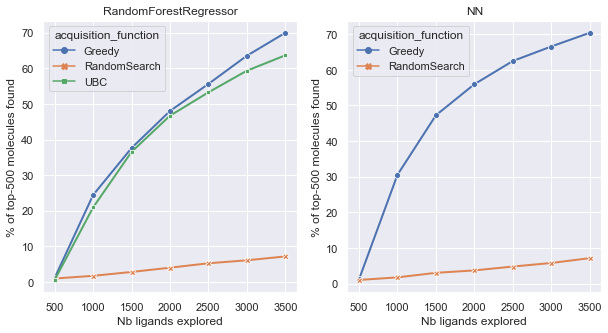

In [257]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for i, ax in enumerate(axs):
    sns.lineplot(data=all_result[i], markers=True, dashes=False, linewidth=2, ax=ax)
    ax.set_xlabel('Nb ligands explored')
    ax.set_ylabel('% of top-500 molecules found')
    ax.set_title(df_results.model.unique()[i])

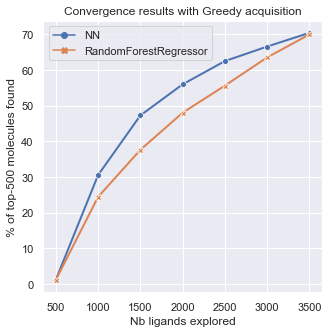

In [258]:
plt.figure(figsize=(5, 5))

ax = sns.lineplot(data=result_per_model.T.iloc[:, result_per_model.T.columns.get_level_values(1)=='Greedy'], 
                  markers=True, 
                  dashes=False, 
                  linewidth=2)

plot = ax.set_xlabel('Nb ligands explored')
plot = ax.set_ylabel('% of top-500 molecules found')
plot = ax.set_title('Convergence results with Greedy acquisition')

In [215]:
# Save % molecule found by the RandomSearch as the baseline
baseline = result_per_model.iloc[1][-1]

for idx in result_per_model.index:
    if idx[1] != 'RandomSearch':
        ef = result_per_model.loc[idx][-1] / baseline
        print(idx[0],'with acquisition function',idx[1],'has an enrichment factor of', round(ef, 2))

NN with acquisition function Greedy has an enrichment factor of 9.89
RandomForestRegressor with acquisition function Greedy has an enrichment factor of 9.83
RandomForestRegressor with acquisition function UBC has an enrichment factor of 8.94
